# Airbnb NYC project

### Import Fonctions

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
from folium.plugins import HeatMap
import statsmodels.formula.api as smf
from sklearn.utils import shuffle
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

### Import dataset

In [2]:
airbnb_df=pd.read_csv('listings_6mai2020.csv')

C:\Users\Diane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50246 entries, 0 to 50245
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(21), object(64)
memory usage: 40.6+ MB


# Data Preprocessing

### Drop columns

In [4]:
# Drop non-relevant, redundant, empty or not useful columns
airbnb_df = airbnb_df.drop(columns=['listing_url','scrape_id','last_scraped','name','summary','space','description',
                                   'experiences_offered','neighborhood_overview','notes','transit','access','interaction',
                                   'house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id',
                                    'host_url','host_name','host_since','host_location','host_about','host_response_time',
                                   'host_thumbnail_url','host_picture_url','host_neighbourhood','host_total_listings_count',
                                   'host_verifications','street','neighbourhood','neighbourhood_group_cleansed','city',
                                   'state','zipcode','market','smart_location','country_code','country','latitude',
                                    'longitude','amenities','square_feet','weekly_price','monthly_price',
                                    'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                                    'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
                                    'calendar_updated','has_availability','availability_30','availability_60',
                                    'availability_90','calendar_last_scraped','number_of_reviews_ltm','first_review',
                                   'last_review','license','jurisdiction_names','host_acceptance_rate',
                                    'calculated_host_listings_count_entire_homes','security_deposit','cleaning_fee',
                                    'calculated_host_listings_count_private_rooms','reviews_per_month',
                                    'calculated_host_listings_count_shared_rooms','host_response_rate',
                                   'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                                   'review_scores_checkin','review_scores_communication','review_scores_location',
                                   'review_scores_value','neighbourhood_cleansed','host_listings_count'])

In [5]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50246 entries, 0 to 50245
Data columns (total 26 columns):
id                                  50246 non-null int64
host_is_superhost                   50235 non-null object
host_has_profile_pic                50235 non-null object
host_identity_verified              50235 non-null object
is_location_exact                   50246 non-null object
property_type                       50246 non-null object
room_type                           50246 non-null object
accommodates                        50246 non-null int64
bathrooms                           50174 non-null float64
bedrooms                            50125 non-null float64
beds                                49718 non-null float64
bed_type                            50234 non-null object
price                               50246 non-null object
guests_included                     50246 non-null int64
extra_people                        50246 non-null object
minimum_nights       

### Remove rare property_type

In [6]:
airbnb_df.property_type.value_counts()

Apartment                 39079
House                      4065
Townhouse                  1768
Condominium                1764
Loft                       1356
Serviced apartment          472
Boutique hotel              451
Guest suite                 425
Hotel                       323
Other                       104
Guesthouse                   77
Resort                       73
Bed and breakfast            62
Hostel                       51
Villa                        29
Bungalow                     26
Aparthotel                   25
Tiny house                   22
Camper/RV                    15
Boat                          9
Cottage                       7
Earth house                   6
Tent                          5
Cave                          4
Houseboat                     3
Casa particular (Cuba)        3
Castle                        3
Lighthouse                    2
Dome house                    2
Barn                          2
Cabin                         2
Yurt    

In [7]:
# Rare property_type list
property_type_rare=airbnb_df.property_type.value_counts()<10
property_type_rare=property_type_rare[property_type_rare==True]
property_type_rare.index

Index(['Boat', 'Cottage', 'Earth house', 'Tent', 'Cave', 'Houseboat',
       'Casa particular (Cuba)', 'Castle', 'Lighthouse', 'Dome house', 'Barn',
       'Cabin', 'Yurt', 'Island', 'Bus', 'Treehouse', 'Train', 'Farm stay',
       'Dorm', 'In-law', 'Timeshare'],
      dtype='object')

In [8]:
# Remove rare property_type rows
for p in property_type_rare.index:
    airbnb_df=airbnb_df[airbnb_df.property_type != p]

### Remove missing values in bed_type column

In [9]:
airbnb_df=airbnb_df.dropna(axis=0,subset=['bed_type'])

### Convert categorical columns 

In [10]:
# Select columns
categorical_column=airbnb_df[['property_type','room_type','bed_type','cancellation_policy']]

In [11]:
# Delete columns in original dataset
airbnb_df=airbnb_df.drop(['property_type','room_type','bed_type','cancellation_policy'],axis=1)

In [12]:
# Convert columns
categorical_df=pd.get_dummies(categorical_column)

In [13]:
# Concat new columns with original dataset
airbnb_df=pd.concat([airbnb_df,categorical_df],axis='columns')

In [14]:
# Remove one column of each category
airbnb_df=airbnb_df.drop(['property_type_Other','room_type_Shared room','bed_type_Airbed',
                          'cancellation_policy_super_strict_60'],axis=1)

### Remove $ sign

In [15]:
# Replace $ sign and commas by a space in the price column
airbnb_df.price = airbnb_df.price.str.replace('$', '')
airbnb_df.price = airbnb_df.price.str.replace(',', '')
airbnb_df.price = airbnb_df.price.astype('float')

In [16]:
# Replace $ sign and commas by a space in the extra_people column
airbnb_df.extra_people = airbnb_df.extra_people.str.replace('$', '')
airbnb_df.extra_people = airbnb_df.extra_people.str.replace(',', '')
airbnb_df.extra_people = airbnb_df.extra_people.astype('float')

### Convert t (True) and f (False) columns into categorical columns

In [17]:
# Select t (True) and f (False) columns
true_false_columns=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
                             'requires_license','instant_bookable','is_business_travel_ready',
                              'require_guest_profile_picture','require_guest_phone_verification']

In [18]:
# Transform 't' in 1 and 'f' in 0
for column in true_false_columns:
    airbnb_df[column]=airbnb_df[column].str.replace('t','1')
    airbnb_df[column]=airbnb_df[column].str.replace('f','0')

In [19]:
# Replace missing values by 0
airbnb_df.host_is_superhost=airbnb_df.host_is_superhost.fillna(0)
airbnb_df.host_has_profile_pic=airbnb_df.host_has_profile_pic.fillna(0)
airbnb_df.host_identity_verified=airbnb_df.host_identity_verified.fillna(0)

In [20]:
# Convert objects columns into integer columns
for column in true_false_columns:
    airbnb_df[column]=airbnb_df[column].astype('int64')

### Replace missing values

In [21]:
# bathrooms, bedrooms and beds columns
airbnb_df.bathrooms=airbnb_df.bathrooms.fillna(0)
airbnb_df.bedrooms=airbnb_df.bedrooms.fillna(0)
airbnb_df.beds=airbnb_df.beds.fillna(0)

### New dataset

In [22]:
airbnb_df.columns=['id','host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'availability_365',
       'number_of_reviews', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'property_type_Aparthotel', 'property_type_Apartment',
       'property_type_Bed_and_breakfast', 'property_type_Boutique_hotel',
       'property_type_Bungalow', 'property_type_Camper_RV',
       'property_type_Condominium', 'property_type_Guest_suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Loft',
       'property_type_Resort',
       'property_type_Serviced_apartment', 'property_type_Tiny_house',
       'property_type_Townhouse', 'property_type_Villa',
       'room_type_Entire_home_apt', 'room_type_Hotel_room',
       'room_type_Private_room',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull_out_Sofa',
       'bed_type_Real_Bed', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30']

In [23]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50175 entries, 0 to 50245
Data columns (total 52 columns):
id                                                 50175 non-null int64
host_is_superhost                                  50175 non-null int64
host_has_profile_pic                               50175 non-null int64
host_identity_verified                             50175 non-null int64
is_location_exact                                  50175 non-null int64
accommodates                                       50175 non-null int64
bathrooms                                          50175 non-null float64
bedrooms                                           50175 non-null float64
beds                                               50175 non-null float64
price                                              50175 non-null float64
guests_included                                    50175 non-null int64
extra_people                                       50175 non-null float64
minimum_nights   

## Deuxieme dataset - Location

In [24]:
airbnb_df2=pd.read_csv('listings.csv')
airbnb_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50246 entries, 0 to 50245
Data columns (total 16 columns):
id                                50246 non-null int64
name                              50228 non-null object
host_id                           50246 non-null int64
host_name                         50235 non-null object
neighbourhood_group               50246 non-null object
neighbourhood                     50246 non-null object
latitude                          50246 non-null float64
longitude                         50246 non-null float64
room_type                         50246 non-null object
price                             50246 non-null int64
minimum_nights                    50246 non-null int64
number_of_reviews                 50246 non-null int64
last_review                       39216 non-null object
reviews_per_month                 39216 non-null float64
calculated_host_listings_count    50246 non-null int64
availability_365                  50246 non-null int64

In [25]:
airbnb_df2=airbnb_df2[['id','neighbourhood_group']]

### Convert neighbourhood_group into numeric columns 

In [26]:
airbnb_df2=pd.get_dummies(airbnb_df2,columns=['neighbourhood_group'])

In [27]:
airbnb_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50246 entries, 0 to 50245
Data columns (total 6 columns):
id                                   50246 non-null int64
neighbourhood_group_Bronx            50246 non-null uint8
neighbourhood_group_Brooklyn         50246 non-null uint8
neighbourhood_group_Manhattan        50246 non-null uint8
neighbourhood_group_Queens           50246 non-null uint8
neighbourhood_group_Staten Island    50246 non-null uint8
dtypes: int64(1), uint8(5)
memory usage: 638.0 KB


In [28]:
# Delete one column
airbnb_df2=airbnb_df2.drop(['neighbourhood_group_Staten Island'],axis=1)

In [29]:
airbnb_df2.head()

,id,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens
0,2060,0,0,1,0
1,2595,0,0,1,0
2,3831,0,1,0,0
3,5099,0,0,1,0
4,5121,0,1,0,0


## Datasets concatenation 

In [30]:
airbnb_df=pd.merge(airbnb_df,airbnb_df2,on=['id','id'])

## Outliers

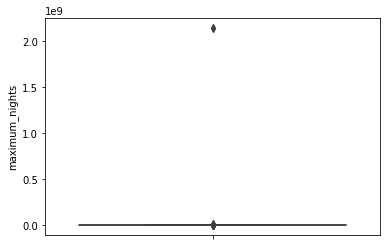

In [31]:
# Outliers maximum_nights column
_ = sns.boxplot(y = 'maximum_nights', data=airbnb_df)
plt.show()

In [32]:
# Remove Outliers maximum_nights column
airbnb_df=airbnb_df[airbnb_df.maximum_nights<8000]
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50165 entries, 0 to 50174
Data columns (total 56 columns):
id                                                 50165 non-null int64
host_is_superhost                                  50165 non-null int64
host_has_profile_pic                               50165 non-null int64
host_identity_verified                             50165 non-null int64
is_location_exact                                  50165 non-null int64
accommodates                                       50165 non-null int64
bathrooms                                          50165 non-null float64
bedrooms                                           50165 non-null float64
beds                                               50165 non-null float64
price                                              50165 non-null float64
guests_included                                    50165 non-null int64
extra_people                                       50165 non-null float64
minimum_nights   

# Data Visualisation

In [33]:
df=pd.read_csv('listings.csv')
#Count the total listings in each neighbourhood
nh_counts = df['neighbourhood'].value_counts(dropna=False)

#Get the average price of listings in each neighbourhood
nh_price = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

# This shows the popularity of different neighbourhoods in New York
nh_avail = df.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=False)

In [34]:
#Load geodata with geometry information of the neighbourhoods in New York
with open('neighbourhoods.geojson') as f:
    geodata = json.load(f)
    
#Create a GeoDataFrame from geodata    
nh_gdf = GeoDataFrame.from_features(geodata)

In [35]:
aa_1=nh_gdf.neighbourhood
aa_2=df.neighbourhood
aa_1=set(aa_1)
aa_2=set(aa_2)
aa_3=aa_1.difference(aa_2)
aa_3=list(aa_3)

In [36]:
for x in aa_3:
    nh_gdf=nh_gdf[nh_gdf.neighbourhood != x]

In [37]:
nh_gdf=nh_gdf.drop_duplicates(['neighbourhood'])

In [38]:
#Delete the empty column 'neighbourhood_group'
del nh_gdf['neighbourhood_group']

#Set the GeoDataFrame's index to 'neighbourhood'
nh_gdf = nh_gdf.set_index('neighbourhood')

In [39]:
#Combine the GeoDataFrame nh_gdf with other neighbourhood dfs.
neighbourhood_gdf = pd.concat([nh_gdf, nh_counts, nh_price, nh_avail], axis=1, join='outer', sort=True)
neighbourhood_gdf = neighbourhood_gdf.dropna(how='any')
neighbourhood_gdf = neighbourhood_gdf.rename(index=str, columns={'neighbourhood':'total listings'})
neighbourhood_gdf.head()

,geometry,total listings,price,availability_365
Allerton,"(POLYGON ((-73.848597 40.87167, -73.845823 40....",45,104.088889,153.733333
Arden Heights,"(POLYGON ((-74.169827 40.561078, -74.169822999...",5,82.600000,176.400000
Arrochar,"(POLYGON ((-74.06077999999999 40.593188, -74.0...",20,103.100000,245.300000
Arverne,"(POLYGON ((-73.789535 40.599972, -73.789541 40...",74,182.432432,176.432432
Astoria,"(POLYGON ((-73.90160299999999 40.76777, -73.90...",922,103.018438,117.172451


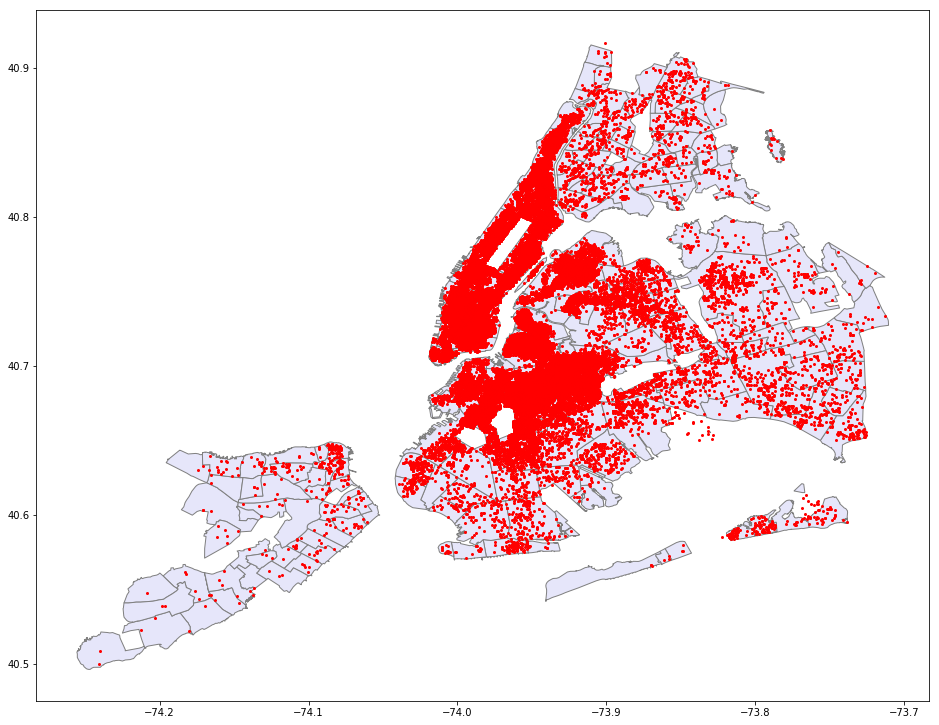

In [40]:
loc = zip(df['longitude'], df['latitude'])
geometry = [Point(xy) for xy in loc]
crs = {'init': 'epsg:4269'}
listing_geo = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
base = neighbourhood_gdf.plot(color='lavender', edgecolor='grey', figsize=(16,16))
listing_geo.plot(ax=base, marker='o', color='red', markersize = 4)
plt.show()

C:\Users\Diane\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Number of listings by neighbourhood')

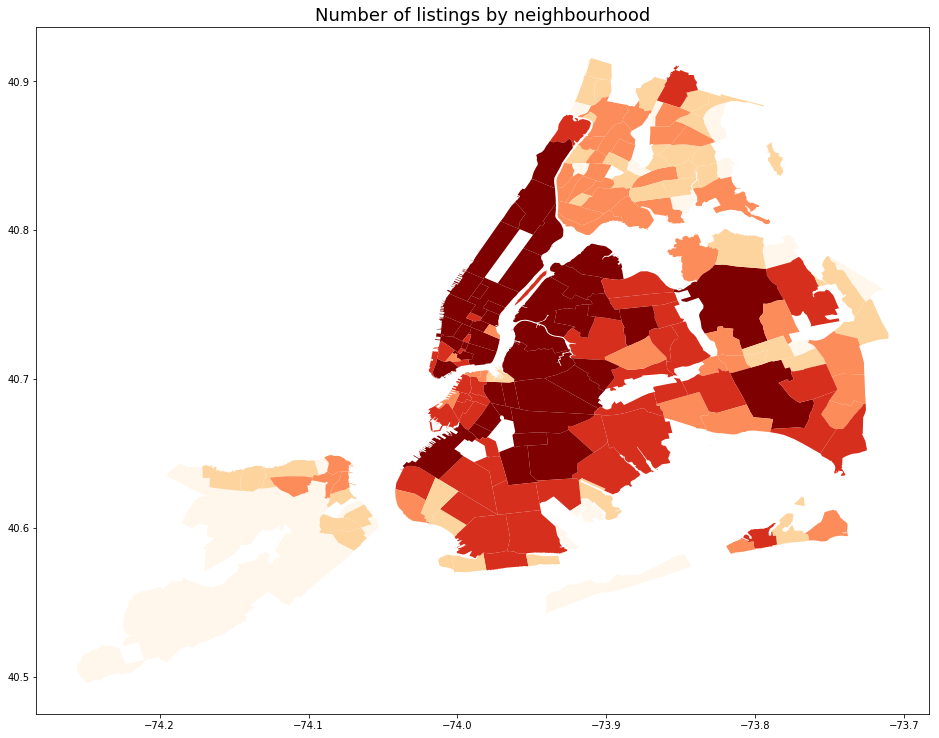

In [41]:
neighbourhood_gdf.plot(column='total listings', cmap='OrRd', figsize=(16,16), scheme='quantiles')
plt.title('Number of listings by neighbourhood', {'fontsize': 18})

Text(0.5, 1.0, 'Average listing price per night by neighbourhood')

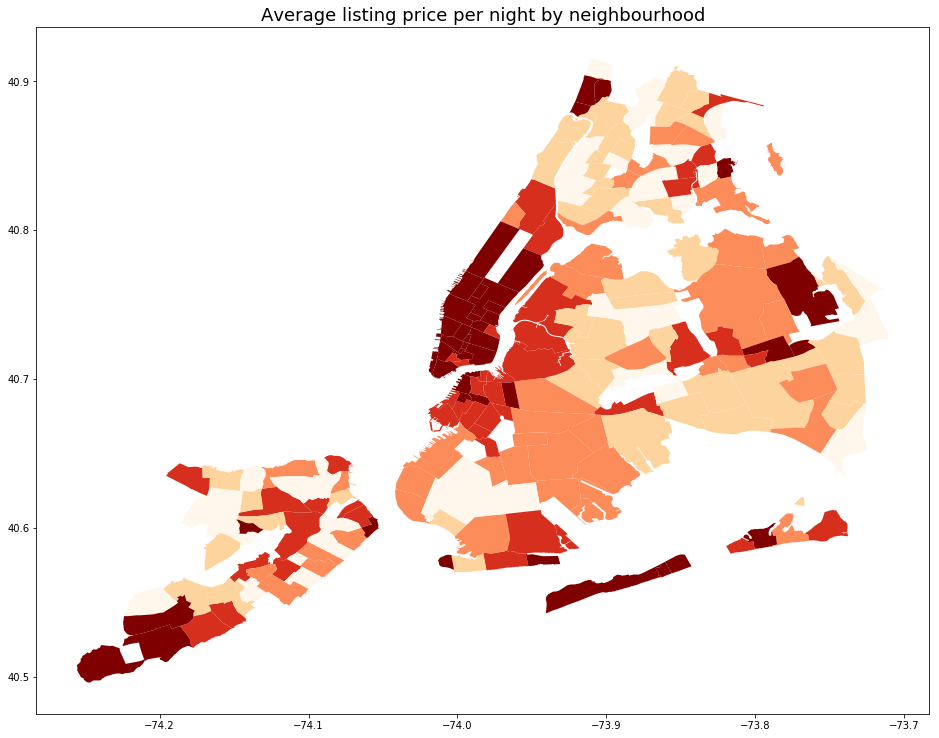

In [42]:
neighbourhood_gdf.plot(column='price', cmap='OrRd', figsize=(16,16), scheme='quantiles')
plt.title('Average listing price per night by neighbourhood', {'fontsize': 18})

Text(0.5, 1.0, 'Average days available for booking in one year')

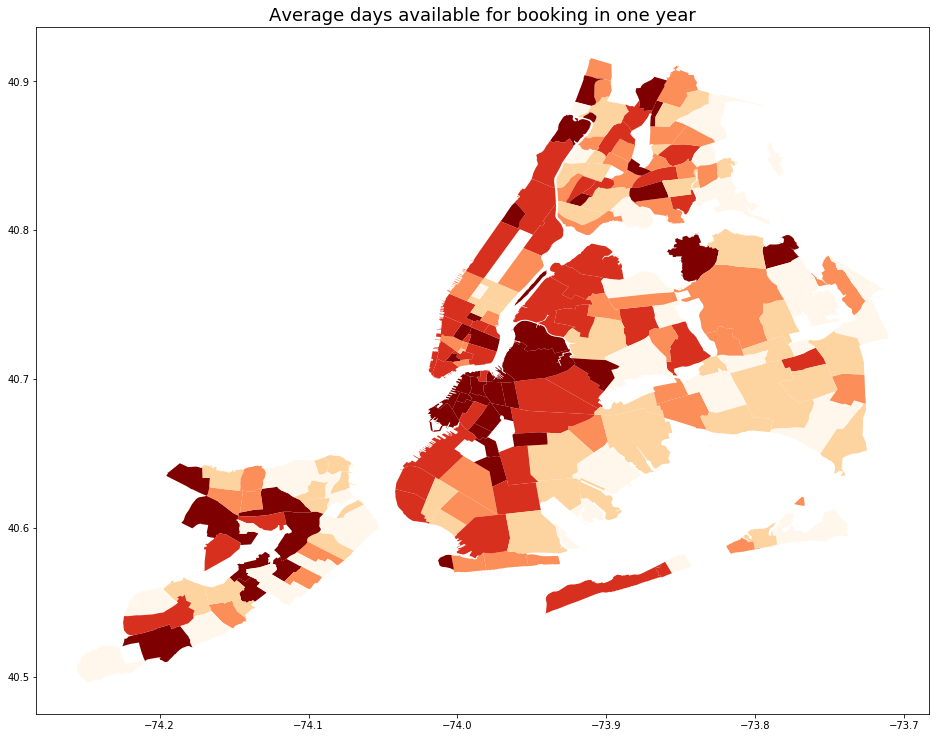

In [43]:
#Use a reverse cmap to indicate the availability_365, because the less available the listing, the more popular it is.
neighbourhood_gdf.plot(column='availability_365', cmap='OrRd_r', figsize=(16,16), scheme='quantiles')
plt.title('Average days available for booking in one year', {'fontsize': 18})

### Heat Map

In [44]:
# New York City Map
NYC_map=folium.Map(location=[40.758896, -73.985130],zoom_start = 11)

Lat_Lon_Val = df[['latitude', 'longitude','price']]
Lat_Lon_Val = Lat_Lon_Val.dropna(axis=0, subset=['latitude','longitude','price'])

# List comprehension to make out list of lists
Data = [[row['latitude'],row['longitude'],row['price']] for index, row in Lat_Lon_Val.iterrows()]

Max_amount = float(df['price'].max())

# Plot it on the map
HeatMap(Data,radius=14, max_val=Max_amount, max_zoom=1).add_to(NYC_map)

# Markers Cities
folium.Marker([40.837048, -73.865433], popup='Bronx').add_to(NYC_map)
folium.Marker([40.696011, -73.993286], popup='Brooklyn').add_to(NYC_map)
folium.Marker([40.758896, -73.985130], popup='Manhanttan').add_to(NYC_map)
folium.Marker([40.768452, -73.832764], popup='Queens').add_to(NYC_map)
folium.Marker([40.5795317, -74.1502007], popup='Staten Island').add_to(NYC_map)
    
# Display the map
NYC_map.save('NYC.html')

### Bar Plot

In [45]:
host_by_neighborhood_sum=df.groupby('neighbourhood_group')[['calculated_host_listings_count','number_of_reviews']].sum()
host_by_neighborhood_sum

,calculated_host_listings_count,number_of_reviews
neighbourhood_group,,
Bronx,2591,33593
Brooklyn,48598,516073
Manhattan,262381,476604
Queens,39713,186318
Staten Island,765,13966


In [46]:
host_by_type_sum=df.groupby('room_type')[['calculated_host_listings_count','number_of_reviews']].sum()
host_by_type_sum

,calculated_host_listings_count,number_of_reviews
room_type,,
Entire home/apt,251453,635720
Hotel room,5605,8677
Private room,91790,562709
Shared room,5200,19448


In [47]:
host_by_neighborhood_mean=df.groupby('neighbourhood_group')[['price']].mean()
host_by_neighborhood_mean

,price
neighbourhood_group,
Bronx,90.866555
Brooklyn,125.147547
Manhattan,219.378652
Queens,99.725118
Staten Island,117.321622


In [48]:
host_by_type_mean=df.groupby('room_type')[['price']].mean()
host_by_type_mean

,price
room_type,
Entire home/apt,207.971848
Hotel room,265.693548
Private room,113.018231
Shared room,91.937719


In [49]:
host_by_neighborhood_count=df.groupby('neighbourhood_group')[['price']].count()
host_by_neighborhood_count.columns=['airbnb_number']
host_by_neighborhood_count

,airbnb_number
neighbourhood_group,
Bronx,1199
Brooklyn,20136
Manhattan,22382
Queens,6159
Staten Island,370


In [50]:
host_by_type_count=df.groupby('room_type')[['price']].count()
host_by_type_count.columns=['airbnb_number']
host_by_type_count

,airbnb_number
room_type,
Entire home/apt,26073
Hotel room,434
Private room,22599
Shared room,1140


In [51]:
host_by_neighborhood=pd.concat([host_by_neighborhood_sum,host_by_neighborhood_mean,host_by_neighborhood_count],axis='columns')
host_by_neighborhood

,calculated_host_listings_count,number_of_reviews,price,airbnb_number
neighbourhood_group,,,,
Bronx,2591,33593,90.866555,1199
Brooklyn,48598,516073,125.147547,20136
Manhattan,262381,476604,219.378652,22382
Queens,39713,186318,99.725118,6159
Staten Island,765,13966,117.321622,370


In [52]:
host_by_type=pd.concat([host_by_type_sum,host_by_type_mean,host_by_type_count],axis='columns')
host_by_type

,calculated_host_listings_count,number_of_reviews,price,airbnb_number
room_type,,,,
Entire home/apt,251453,635720,207.971848,26073
Hotel room,5605,8677,265.693548,434
Private room,91790,562709,113.018231,22599
Shared room,5200,19448,91.937719,1140


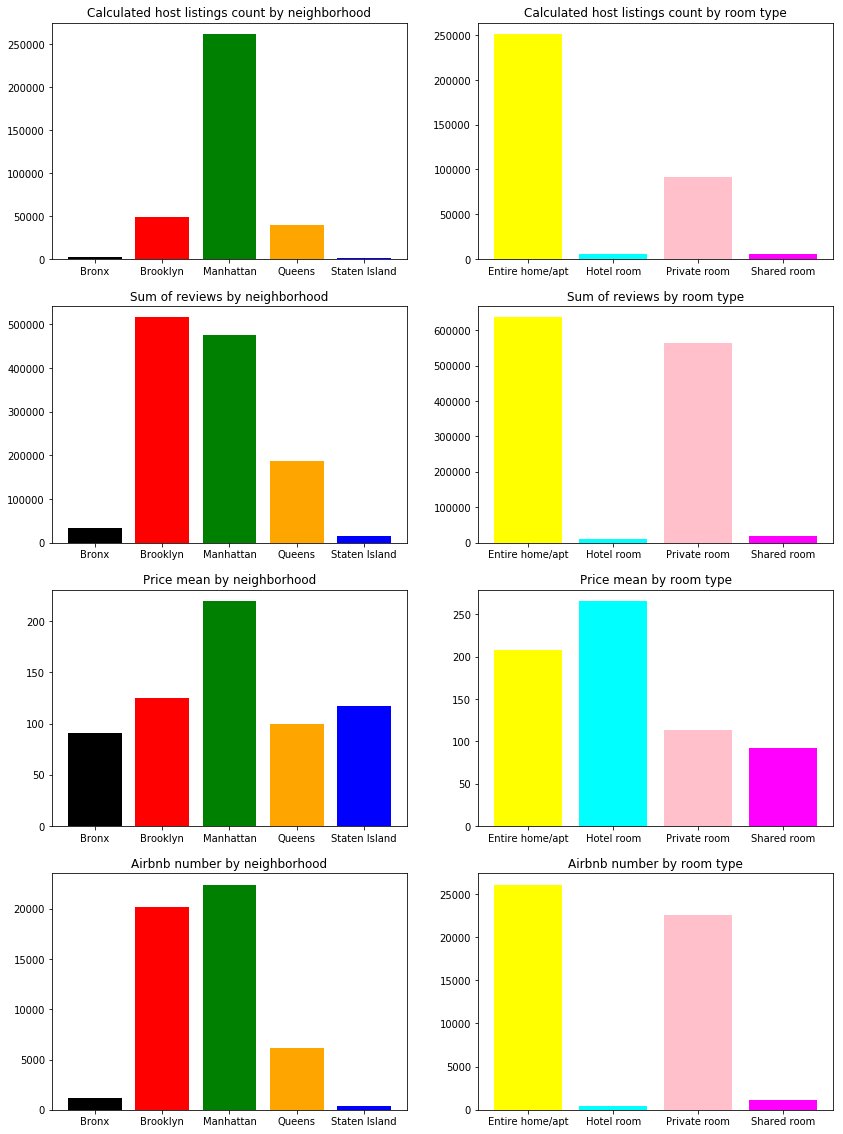

In [53]:
fig = plt.figure(figsize=(14,20))

# Calculated host listings count by neighborhood
ax1 = plt.subplot(4,2,1)
ax1.bar(arange(5)+1,host_by_neighborhood['calculated_host_listings_count'],color=['black', 'red', 'green', 'orange', 'blue'])
ax1.set_title('Calculated host listings count by neighborhood')
ax1.set_xticks(range(1,6))
ax1.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],rotation=0)

# Calculated host listings count by room type
ax2 = plt.subplot(4,2,2)
ax2.bar(arange(4)+1,host_by_type['calculated_host_listings_count'],color=['yellow', 'cyan', 'pink','magenta'])
ax2.set_title('Calculated host listings count by room type')
ax2.set_xticks(range(1,5))
ax2.set_xticklabels(['Entire home/apt','Hotel room','Private room','Shared room'],rotation=0)

# Sum of reviews by neighborhood
ax3 = plt.subplot(4,2,3)
ax3.bar(arange(5)+1,host_by_neighborhood['number_of_reviews'],color=['black', 'red', 'green', 'orange', 'blue'])
ax3.set_title('Sum of reviews by neighborhood')
ax3.set_xticks(range(1,6))
ax3.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],rotation=0)

# Sum of reviews by room type
ax4 = plt.subplot(4,2,4)
ax4.bar(arange(4)+1,host_by_type['number_of_reviews'],color=['yellow', 'cyan', 'pink','magenta'])
ax4.set_title('Sum of reviews by room type')
ax4.set_xticks(range(1,5))
ax4.set_xticklabels(['Entire home/apt','Hotel room','Private room','Shared room'],rotation=0)

# Price mean by neighborhood
ax5 = plt.subplot(4,2,5)
ax5.bar(arange(5)+1,host_by_neighborhood['price'],color=['black', 'red', 'green', 'orange', 'blue'])
ax5.set_title('Price mean by neighborhood')
ax5.set_xticks(range(1,6))
ax5.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],rotation=0)

# Price mean by room type
ax6 = plt.subplot(4,2,6)
ax6.bar(arange(4)+1,host_by_type['price'],color=['yellow', 'cyan', 'pink','magenta'])
ax6.set_title('Price mean by room type')
ax6.set_xticks(range(1,5))
ax6.set_xticklabels(['Entire home/apt','Hotel room','Private room','Shared room'],rotation=0)

# Airbnb number by neighborhood
ax7 = plt.subplot(4,2,7)
ax7.bar(arange(5)+1,host_by_neighborhood['airbnb_number'],color=['black', 'red', 'green', 'orange', 'blue'])
ax7.set_title('Airbnb number by neighborhood')
ax7.set_xticks(range(1,6))
ax7.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],rotation=0)

# Airbnb number by room type
ax8 = plt.subplot(4,2,8)
ax8.bar(arange(4)+1,host_by_type['airbnb_number'],color=['yellow', 'cyan', 'pink','magenta'])
ax8.set_title('Airbnb number by room type')
ax8.set_xticks(range(1,5))
ax8.set_xticklabels(['Entire home/apt','Hotel room','Private room','Shared room'],rotation=0)

plt.show()

In [54]:
# Divided by airbnb number
review_by_airbnb_by_neighborhood=host_by_neighborhood['number_of_reviews']/host_by_neighborhood['airbnb_number']
review_by_airbnb_by_type=host_by_type['number_of_reviews']/host_by_type['airbnb_number']

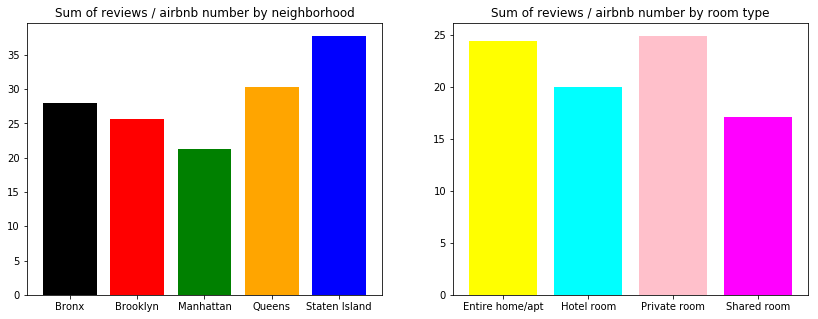

In [55]:
fig = plt.figure(figsize=(14,5))

# Sum of reviews by neighborhood
ax3 = plt.subplot(1,2,1)
ax3.bar(arange(5)+1,review_by_airbnb_by_neighborhood,color=['black', 'red', 'green', 'orange', 'blue'])
ax3.set_title('Sum of reviews / airbnb number by neighborhood')
ax3.set_xticks(range(1,6))
ax3.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],rotation=0)

# Sum of reviews by room type
ax4 = plt.subplot(1,2,2)
ax4.bar(arange(4)+1,review_by_airbnb_by_type,color=['yellow', 'cyan', 'pink','magenta'])
ax4.set_title('Sum of reviews / airbnb number by room type')
ax4.set_xticks(range(1,5))
ax4.set_xticklabels(['Entire home/apt','Hotel room','Private room','Shared room'],rotation=0)
plt.show()

In [56]:
# Number of type rooms by neighborhoods
type_neighborhood=df.groupby(['room_type','neighbourhood_group'])[['price']].count()
type_neighborhood.columns=['Airbnb_number']
type_neighborhood=type_neighborhood.unstack(level='neighbourhood_group')
type_neighborhood

Airbnb_number                                         
neighbourhood_group         Bronx Brooklyn Manhattan  Queens Staten Island
room_type                                                                 
Entire home/apt             428.0   9761.0   13451.0  2248.0         185.0
Hotel room                    NaN     34.0     362.0    38.0           NaN
Private room                728.0   9942.0    8078.0  3670.0         181.0
Shared room                  43.0    399.0     491.0   203.0           4.0

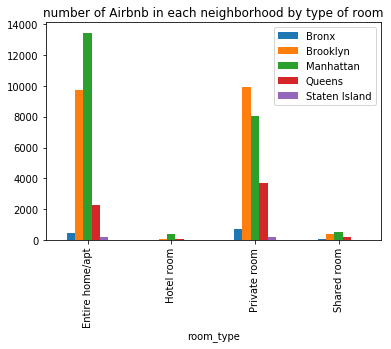

In [57]:
type_neighborhood.plot(kind='bar')
plt.title('number of Airbnb in each neighborhood by type of room')
plt.legend(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.show()

### Histogram

C:\Users\Diane\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


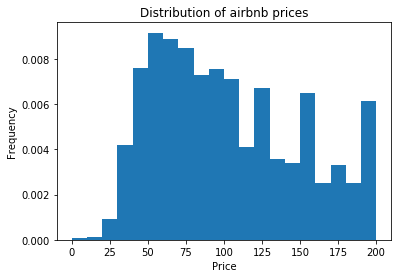

In [58]:
df.plot(y='price', kind='hist', bins=20 , range=(0,200) , normed=True , legend=None)
plt.xlabel('Price')
plt.title('Distribution of airbnb prices')
plt.show()

C:\Users\Diane\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


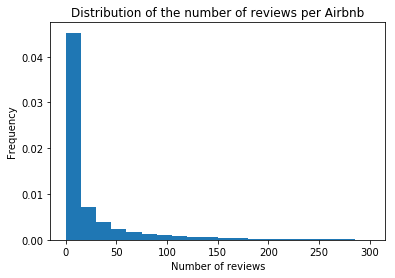

In [59]:
df.plot(y='number_of_reviews', kind='hist', bins=20 , range=(0,300) , normed=True , legend=None)
plt.xlabel('Number of reviews')
plt.title('Distribution of the number of reviews per Airbnb')
plt.show()

C:\Users\Diane\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


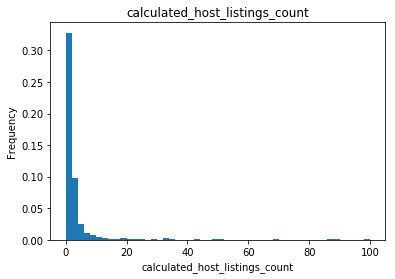

In [60]:
df.plot(y='calculated_host_listings_count', kind='hist', bins=50 , range=(0,100) , normed=True , legend=None)
plt.xlabel('calculated_host_listings_count')
plt.title('calculated_host_listings_count')
plt.show()

C:\Users\Diane\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


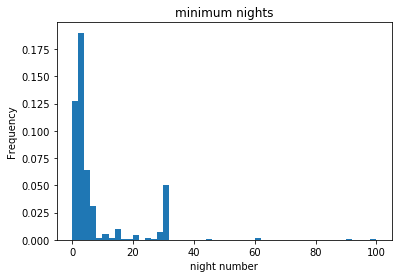

In [61]:
df.plot(y='minimum_nights', kind='hist', bins=50 , range=(0,100) , normed=True , legend=None)
plt.xlabel('night number')
plt.title('minimum nights')
plt.show()

C:\Users\Diane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


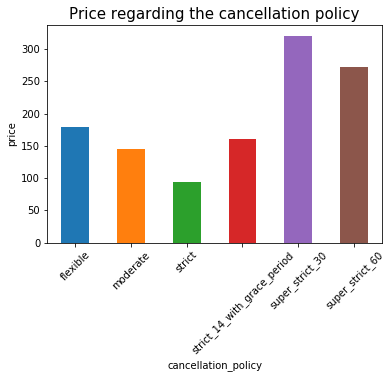

In [62]:
df2=pd.read_csv('listings_6mai2020.csv')
df2.price = df2.price.str.replace('$', '')
df2.price = df2.price.str.replace(',', '')
df2.price = df2.price.astype('float')
df2.groupby('cancellation_policy')['price'].mean().plot(kind='bar', rot=45)
plt.ylabel('price')
plt.title('Price regarding the cancellation policy', fontsize= 15)
plt.show()

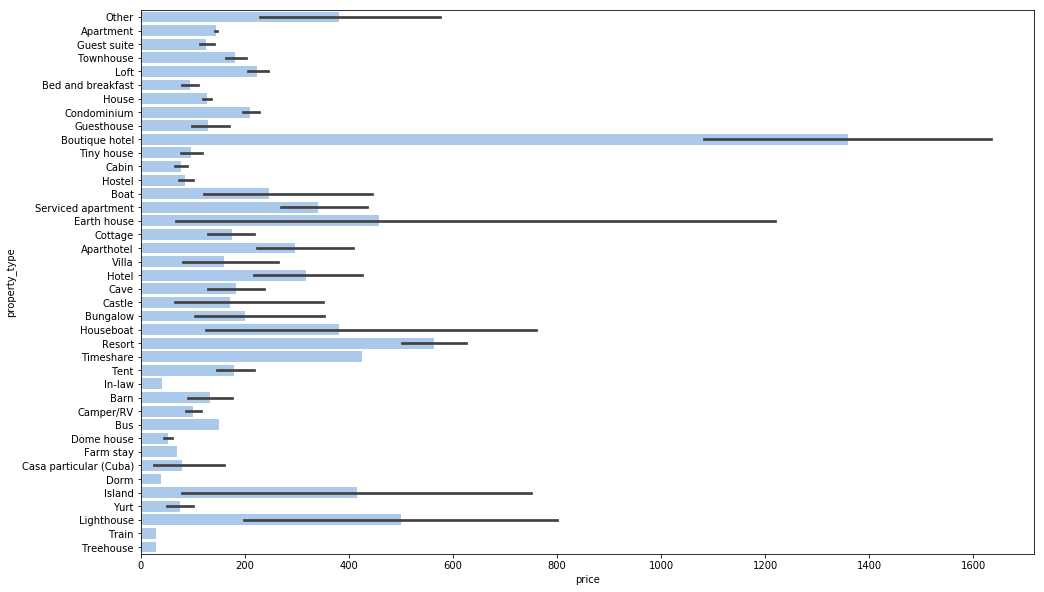

In [63]:
plt.figure(figsize=(16,10))
sns.set_color_codes('pastel')
sns.barplot(x='price', y='property_type', data = df2, color="b")
plt.show()

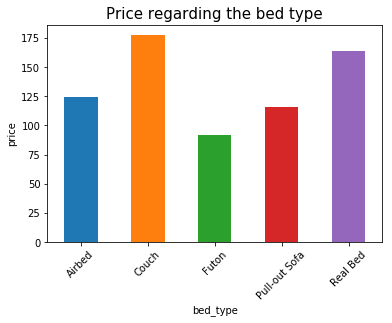

In [64]:
df2.groupby('bed_type')['price'].mean().plot(kind='bar', rot=45)
plt.ylabel('price')
plt.title('Price regarding the bed type', fontsize= 15)
plt.show()

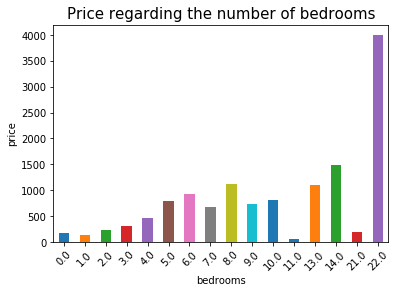

In [65]:
df2=df2.dropna(subset=['bedrooms'])
df2.groupby('bedrooms')['price'].mean().plot(kind='bar', rot=45)
plt.ylabel('price')
plt.title('Price regarding the number of bedrooms', fontsize= 15)
plt.show()

## Exploratory Data Analysis

### ANOVA between the price and the neighborhood group

In [66]:
import researchpy as rp
import scipy.stats as stats

In [67]:
rp.summary_cont(df['price'].groupby(df['neighbourhood_group']))

,N,Mean,SD,SE,95% Conf.,Interval
neighbourhood_group,,,,,,
Bronx,1199,90.866555,102.143532,2.949859,85.082419,96.650692
Brooklyn,20136,125.147547,204.408033,1.440494,122.324109,127.970984
Manhattan,22382,219.378652,586.433521,3.919849,211.695577,227.061728
Queens,6159,99.725118,193.598918,2.466879,94.889643,104.560593
Staten Island,370,117.321622,240.903700,12.523987,92.741368,141.901875


In [68]:
stats.f_oneway(df['price'][df['neighbourhood_group'] == 'Bronx'], 
             df['price'][df['neighbourhood_group'] == 'Brooklyn'],
              df['price'][df['neighbourhood_group'] == 'Manhattan'], 
             df['price'][df['neighbourhood_group'] == 'Queens'],
              df['price'][df['neighbourhood_group'] == "Staten Island"])

F_onewayResult(statistic=187.858785731004, pvalue=4.0340002343318935e-160)

In [69]:
# Some exemple of Bonferroni Correction Post-hoc Comparison 
BC_1=stats.ttest_ind(df['price'][df['neighbourhood_group'] == 'Manhattan'], 
                df['price'][df['neighbourhood_group'] == 'Brooklyn'])
print('Bonferroni Correction between Manhattan and Brooklyn:',BC_1)

BC_2=stats.ttest_ind(df['price'][df['neighbourhood_group'] == 'Manhattan'], 
                df['price'][df['neighbourhood_group'] == "Queens"])
print("Bonferroni Correction between Manhattan and Queens:",BC_2)

BC_3=stats.ttest_ind(df['price'][df['neighbourhood_group'] == 'Brooklyn'], 
                df['price'][df['neighbourhood_group'] == 'Queens'])
print('Bonferroni Correction between Brooklyn and Queens:',BC_3)

BC_4=stats.ttest_ind(df['price'][df['neighbourhood_group'] == 'Queens'], 
                df['price'][df['neighbourhood_group'] == 'Bronx'])
print('Bonferroni Correction between Queens and Bronx:',BC_4)

Bonferroni Correction between Manhattan and Brooklyn: Ttest_indResult(statistic=21.64893688264783, pvalue=2.254299659932896e-103)
Bonferroni Correction between Manhattan and Queens: Ttest_indResult(statistic=15.777584975913957, pvalue=7.647198608868697e-56)
Bonferroni Correction between Brooklyn and Queens: Ttest_indResult(statistic=8.646191340234308, pvalue=5.622635066556549e-18)
Bonferroni Correction between Queens and Bronx: Ttest_indResult(statistic=1.5430998939506404, pvalue=0.12284955605358162)


### Statmodel

In [70]:
results = smf.ols('price ~ host_is_superhost + host_has_profile_pic + host_identity_verified + is_location_exact + accommodates + bathrooms + bedrooms + beds + guests_included + extra_people + minimum_nights + maximum_nights + availability_365 + number_of_reviews + requires_license + instant_bookable + is_business_travel_ready + require_guest_profile_picture + require_guest_phone_verification + calculated_host_listings_count + property_type_Aparthotel + property_type_Apartment + property_type_Bed_and_breakfast + property_type_Boutique_hotel + property_type_Bungalow + property_type_Camper_RV + property_type_Condominium + property_type_Guest_suite + property_type_Guesthouse + property_type_Hostel + property_type_Hotel + property_type_House + property_type_Loft + property_type_Resort + property_type_Serviced_apartment + property_type_Tiny_house + property_type_Townhouse + property_type_Villa + room_type_Entire_home_apt + room_type_Hotel_room + room_type_Private_room + bed_type_Couch + bed_type_Futon + bed_type_Pull_out_Sofa + bed_type_Real_Bed + cancellation_policy_flexible + cancellation_policy_moderate + cancellation_policy_strict + cancellation_policy_strict_14_with_grace_period + cancellation_policy_super_strict_30 + neighbourhood_group_Bronx + neighbourhood_group_Brooklyn + neighbourhood_group_Manhattan + neighbourhood_group_Queens',data=airbnb_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     175.1
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:42:03   Log-Likelihood:            -3.7022e+05
No. Observations:               50165   AIC:                         7.406e+05
Df Residuals:                   50112   BIC:                         7.410e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

# Machine Learning

## Random Forest Regressor

In [71]:
# Import modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [72]:
# Separating dependant and independant variables
X=airbnb_df.drop(['price','id'],axis=1)
y=airbnb_df['price']

In [73]:
# Splitting into train set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=21)

In [74]:
# Finding the best hyperparameter 'max_depth'
param={'max_depth':[2,4,6,8,10,12,14]}
regr=RandomForestRegressor()
regr_cv=GridSearchCV(regr,param,cv=5)
regr_cv.fit(X_train,y_train)
print(regr_cv.best_params_)
print(regr_cv.best_score_)

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

{'max_depth': 8}
0.43585038555529565


In [75]:
# Random Forest Regressor
regr=RandomForestRegressor(max_depth=8,random_state=21)
regr.fit(X_train,y_train)
# Calculating r2 score 
y_pred=regr.predict(X_train)
print('R² Score train data = {}'.format(r2_score(y_train,y_pred)))
y_pred=regr.predict(X_test)
print('R² Score test data = {}'.format(r2_score(y_test,y_pred)))

C:\Users\Diane\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R² Score train data = 0.7157338600539085
R² Score test data = 0.4700738076945117


## Feature importances

In [76]:
importances = regr.feature_importances_
indices = np.argsort(importances)
featurename = [X_train.columns[i] for i in indices]
indices = np.argsort(importances)

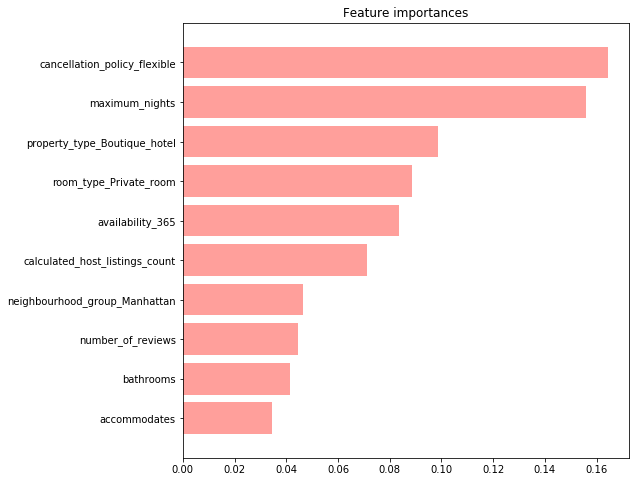

In [77]:
# Plot the feature importances with the feature names
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.barh(range(10), importances[indices][-10:],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), featurename[-10:])
#plt.yticks(range(10), importances[-10:])
plt.ylim([-1, 10])
plt.show()

In [78]:
# Determining feature importances
feature_importances = pd.DataFrame(regr.feature_importances_,index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
cancellation_policy_flexible,0.164420
maximum_nights,0.155774
property_type_Boutique_hotel,0.098875
room_type_Private_room,0.088460
availability_365,0.083642
calculated_host_listings_count,0.071098
neighbourhood_group_Manhattan,0.046358
number_of_reviews,0.044583
bathrooms,0.041620
accommodates,0.034532
